In [46]:
import numpy as np
import pandas as pd
from math import sqrt
from pprint import pprint
from sklearn import datasets
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [13]:
# Cargar y explorar los datos
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]
#datos = datasets.load_boston()
pprint(data)
print(np.shape(data))
print(np.shape(target))

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])
(506, 13)
(506,)


In [14]:
# Extraer la matriz de datos "X" y la variable target "y"
X = data
y = target

In [16]:
# Partición EXTERNA: hold-out split 80% train - 20% test.
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.2,shuffle=True,random_state=42)
print('Train dimensions: ', np.shape(X_train))
print('Test dimensions:  ', np.shape(X_test))

Train dimensions:  (404, 13)
Test dimensions:   (102, 13)


In [18]:
# Estandarización de los datos de entrenamiento y test
standr = preprocessing.StandardScaler()

X_train_std = standr.fit_transform(X_train)

X_test_std = standr.transform(X_test)


In [19]:
# Métricas de evaluación para problemas de regresión
metricas = {
  'MAE': 'neg_mean_absolute_error',
  'RMSE': make_scorer(lambda y, y_pred:
                      sqrt(mean_squared_error(y, y_pred)),
                      greater_is_better=False),
  'MAPE': make_scorer(lambda y, y_pred:
                      np.mean(np.abs((y - y_pred) / y)) * 100,
                      greater_is_better=False)}

In [41]:
# Definimos un algoritmo SVM de regresión
#alg = SVR(C=100, gamma='auto', kernel='rbf')
alg = SVR(C=10, gamma='scale', kernel='rbf')

In [42]:
# Validación y evaluación del modelo.
# en "cv = KFold(n_splits=5)" se hace un cross-validation INTERNO!! 
#La diferencia entre cross validate y score es que con este se puede definir metricas que se desea, en el otro solo es el accuracy
#este método realiza 4 cosas, la partición, entrenamiento, predicción y cálculo de métricas.
results = cross_validate(alg, X_train, y_train, cv = KFold(n_splits=5, shuffle=True, random_state=42), scoring = metricas)

In [43]:
# Presentación de los resultados de la evaluación.
pprint(results)
#Da como resultado el tiempo de entrenamiento, el tiempo de predicción y los valores de las métricas por cada iteración


{'fit_time': array([0.01598597, 0.01328897, 0.01255322, 0.01395607, 0.0136795 ]),
 'score_time': array([0.00408387, 0.00408149, 0.00464153, 0.00461626, 0.00450826]),
 'test_MAE': array([-5.13976503, -5.63095763, -5.48071432, -5.9195339 , -4.35859537]),
 'test_MAPE': array([-24.35163528, -22.77511941, -22.75271465, -23.17904956,
       -21.8290829 ]),
 'test_RMSE': array([-7.35502234, -8.83291393, -9.17195196, -8.92869424, -6.34069404])}


In [44]:
# Una vez hemos optimizado los hiperparámetros en el conjunto de validación, entrenamos un nuevo modelo que contenga
# todos los datos de entrenamiento (es decir, train + validation) para evaluar el test
model = SVR(C=10, gamma='scale', kernel='rbf')
model = model.fit(X_train, y_train)

In [47]:
# Extraemos el error absoluto promedio (MAE) del conjunto de test
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Test results (MAE): ', np.round(mae,4))
print('Test results (r2): ', np.round(r2,4))

Test results (MAE):  4.0773
Test results (r2):  0.3919
Test results (MAE):  4.077331136511674


In [48]:
# También podemos extraer las predicciones para cuánto difieren los valores predichos de los reales
print('Predicciones:   ', np.round(y_pred[:10], 1))
print('Valores reales: ', y_test[:10])

Predicciones:    [22.  26.  15.6 24.5 16.1 20.1 21.  17.8 16.5 20.1]
Valores reales:  [23.6 32.4 13.6 22.8 16.1 20.  17.8 14.  19.6 16.8]


In [49]:
# Grafica de realidad -vs- prediccion.
def grafica_real_vs_pred(y_true, y_pred, metricas, algoritmo):
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred, edgecolors=(0, 0, 0))
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Valor real de la clase')
    ax.set_ylabel('Predicción')
    plt.show()

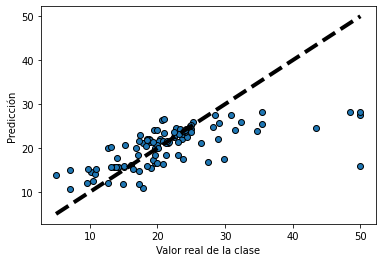

In [50]:
grafica_real_vs_pred(y_test, y_pred, metricas, model)